# Problem Statement

A company with 6 warehouses and 8 retail stores wants to minimize shipping cost while meeting store demand and not exceeding warehouse supply.

## Steps
 Install and import necessary libraries

- Create a synthetic dataset

- Define the Linear Programming model

- Set the objective function

- Add supply and demand constraints

- Solve the model

- Display and interpret the results

- Conclusions

## Step 1: Install and Import Required Libraries
In this step, we'll install and import the necessary Python libraries to build our linear programming model.
We'll be using:

- `pulp`: A library for defining and solving linear optimization problems.
- `numpy`: For generating reproducible random numbers.
- `pandas`: For data manipulation and displaying tables.


We are going to build a linear programming optimization model using the PuLP library.
To simulate a realistic scenario, we’ll use NumPy to generate random data and Pandas to organize and present this data in tabular form.


In [1]:
# Install PuLP
!pip install -q pulp

# Import libraries
import pulp
import numpy as np
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.0 MB/s eta 0:00:00


##  Step 2: Generate a Larger Synthetic Dataset (12 Warehouses, 16 Stores)

To simulate a more complex and professional-level business scenario, we are scaling up our supply chain network.

In this step, we define:

- **12 Warehouses**: These are the supply sources.
- **16 Retail Stores**: These are the demand destinations.
- A **Shipping Cost Matrix**: Represents the per-unit cost of shipping from each warehouse to each store.
- **Supply Capacity**: Total stock available at each warehouse.
- **Store Demand**: Required number of units at each retail store.

This expanded dataset allows us to model a realistic and scalable logistics optimization problem.


We are using the following approach to build the dataset:

- The list of warehouse and store names are generated programmatically for scalability.
- Shipping costs are randomly generated between ₹3 and ₹10 using NumPy.
- Each warehouse has a supply capacity ranging from 500 to 1500 units.
- Each store has a demand ranging from 400 to 1000 units.
- The shipping costs are structured into a matrix (DataFrame) for easier visualization.
- We also create `supply_series` and `demand_series` to keep track of stock and demand.

This setup mirrors real-world uncertainty in transportation costs and varying supply/demand conditions.


In [4]:
# Set seed for reproducibility
np.random.seed(42)

# Define a larger set of warehouses and stores
warehouses = [f"W{i+1}" for i in range(12)]
stores = [f"S{i+1}" for i in range(16)]

# Generate random cost per unit for each warehouse-store pair (₹3 to ₹10)
costs = {(w, s): np.random.randint(3, 11) for w in warehouses for s in stores}

# Generate random supply for each warehouse (500 to 1500 units)
supply = {w: np.random.randint(500, 1501) for w in warehouses}

# Generate random demand for each store (400 to 1000 units)
demand = {s: np.random.randint(400, 1001) for s in stores}

# Create cost matrix DataFrame for visualization
cost_df = pd.DataFrame(index=warehouses, columns=stores)
for w in warehouses:
    for s in stores:
        cost_df.loc[w, s] = costs[(w, s)]

# Convert all entries to integers
cost_df = cost_df.astype(int)

# Create Series for supply and demand
supply_series = pd.Series(supply, name="Supply")
demand_series = pd.Series(demand, name="Demand")

# Display cost matrix
cost_df


,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16
W1,9,6,7,9,5,10,7,7,9,4,5,9,5,5,10,7
W2,6,10,10,5,8,7,4,10,6,8,8,4,10,6,7,3
W3,6,4,8,7,6,3,3,5,5,9,4,10,6,6,10,9
W4,8,8,9,8,5,6,9,6,10,3,5,7,5,9,7,3
W5,9,4,6,3,6,8,4,4,3,4,7,4,6,6,9,6
W6,9,6,7,10,9,5,8,3,6,4,10,6,4,8,8,8
W7,4,6,8,7,9,4,4,6,4,4,8,6,8,9,10,9
W8,10,8,9,6,3,8,10,7,10,7,4,9,7,10,4,3
W9,6,6,6,7,3,7,9,7,3,3,9,3,10,3,6,10
W10,10,9,5,5,3,10,5,5,3,5,7,4,9,4,3,6


In [9]:
# Display warehouse supply
print("🏭 Warehouse Supply (units):")
display(supply_series.to_frame())

# Optional: Check total supply vs total demand
print("⚖️ Total Supply:", supply_series.sum())


🏭 Warehouse Supply (units):


,Supply
W1,892
W2,706
W3,514
W4,1357
W5,1053
W6,1391
W7,960
W8,1190
W9,1074
W10,1363


⚖️ Total Supply: 12482


In [10]:
# Display store demand
print("🛒 Store Demand (units):")
display(demand_series.to_frame())

print("⚖️ Total Demand:", demand_series.sum())

🛒 Store Demand (units):


,Demand
S1,963
S2,495
S3,884
S4,806
S5,630
S6,570
S7,940
S8,435
S9,924
S10,559


⚖️ Total Demand: 11666


## Step 3: Define the Linear Programming Model with Warehouse Activation Costs

In this step, we enhance our supply chain model by including fixed activation costs for warehouses.  
We introduce binary variables to indicate whether a warehouse is used and link shipments to these activations.


### Model Enhancements:

- Introduce binary variables \( y_w \) for each warehouse \( w \), where:
  \[
    y_w = \begin{cases}
      1 & \text{if warehouse } w \text{ ships any units} \\
      0 & \text{otherwise}
    \end{cases}
  \]
  
- Shipment variables \( x_{w,s} \) must satisfy:
  \[
    x_{w,s} \leq M \times y_w
  \]
  where \( M \) is a large number ensuring shipments occur only if warehouse is active.

- The objective function is updated to:
  \[
    \min \sum_{w,s} \text{cost}_{w,s} \times x_{w,s} + \sum_w \text{activation\_cost}_w \times y_w
  \]

This encourages the model to balance shipping costs with the fixed cost of opening warehouses.


In [14]:
# Large constant M, should be >= max possible shipment (e.g., max supply)
M = supply_series.max()

# Updated activation costs for 12 warehouses
activation_costs = {
    'W1': 1000,
    'W2': 1050,
    'W3': 1100,
    'W4': 1150,
    'W5': 1200,
    'W6': 1250,
    'W7': 1300,
    'W8': 1350,
    'W9': 1400,
    'W10': 1450,
    'W11': 1500,
    'W12': 1550
}

# Initialize problem
prob = pulp.LpProblem("Supply_Chain_with_Activation", pulp.LpMinimize)

# Decision variables: shipment amounts
x = pulp.LpVariable.dicts("ship",
                          ((w, s) for w in warehouses for s in stores),
                          lowBound=0,
                          cat='Continuous')

# Decision variables: warehouse activation (binary)
y = pulp.LpVariable.dicts("activate", warehouses, cat='Binary')

# Objective: minimize shipping cost + activation costs
prob += (
    pulp.lpSum(costs[(w, s)] * x[(w, s)] for w in warehouses for s in stores) +
    pulp.lpSum(activation_costs[w] * y[w] for w in warehouses),
    "Total_Cost_with_Activation"
)

# Demand constraints
for s in stores:
    prob += pulp.lpSum(x[(w, s)] for w in warehouses) == demand_series[s], f"Demand_at_{s}"

# Supply constraints
for w in warehouses:
    prob += pulp.lpSum(x[(w, s)] for s in stores) <= supply_series[w], f"Supply_at_{w}"

# Activation constraints: shipment only if warehouse active
for w in warehouses:
    for s in stores:
        prob += x[(w, s)] <= M * y[w], f"Link_ship_activate_{w}_{s}"


##  Step 4: Solve the Optimization Problem and Analyze the Results

In this step, we:

- Solve the linear programming problem formulated previously.
- Extract and display the optimal shipment plan.
- Identify which warehouses are activated.
- Calculate the total cost considering shipping and activation.
- Provide insights on warehouse usage and shipment distribution.


### Explanation:

- We use PuLP's built-in solver (`prob.solve()`) to find the optimal solution.
- After solving, we extract values of shipment variables \( x_{w,s} \) and activation variables \( y_w \).
- We create a shipment matrix showing how many units each warehouse ships to each store.
- We identify which warehouses are active based on \( y_w \) values.
- We compute the total cost from the objective value.
- This helps us understand the cost-efficient shipment plan and warehouse utilization.


In [15]:
# Solve the problem
prob.solve()

# Check solver status
print("Status:", pulp.LpStatus[prob.status])

# Extract and display shipment amounts in a DataFrame
shipment_plan = pd.DataFrame(0, index=warehouses, columns=stores)

for w in warehouses:
    for s in stores:
        shipment_plan.loc[w, s] = x[(w, s)].varValue

# Display warehouses that are active
active_warehouses = [w for w in warehouses if y[w].varValue > 0.5]

print(f"Active Warehouses: {active_warehouses}")

# Display total cost
total_cost = pulp.value(prob.objective)
print(f"Total Cost (Shipping + Activation): {total_cost:.2f}")

shipment_plan


Status: Optimal
Active Warehouses: ['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12']
Total Cost (Shipping + Activation): 55022.00


,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16
W1,0,0,0,0,0,0,0,0,0,0,0,0,21,521,0,0
W2,3,0,0,0,0,0,426,0,0,0,0,277,0,0,0,0
W3,0,0,0,0,0,0,514,0,0,0,0,0,0,0,0,0
W4,0,0,0,0,0,0,0,0,0,559,0,0,0,0,0,427
W5,0,0,0,806,0,0,0,0,247,0,0,0,0,0,0,0
W6,0,0,0,0,0,0,0,435,0,0,0,0,956,0,0,0
W7,960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
W8,0,0,0,0,548,0,0,0,0,0,642,0,0,0,0,0
W9,0,0,0,0,0,0,0,0,431,0,0,208,0,435,0,0
W10,0,0,144,0,0,0,0,0,246,0,0,0,0,0,973,0


##  Step 5: Visualize Shipment Plan and Derive Business Insights

In this step, we will:

- Create heatmaps to visually analyze shipment quantities from warehouses to stores.
- Summarize total shipments per warehouse and per store.
- Gain insights into the logistics efficiency and warehouse utilization.
- Discuss possible improvements or business implications.


### Explanation:

- We use seaborn heatmaps to visualize the shipment matrix for easy pattern recognition.
- A bar plot shows the total units shipped from each warehouse, indicating workload distribution.
- Another bar plot shows total units received by each store, helping identify high-demand stores.
- This visual analysis helps stakeholders quickly grasp the solution and make informed decisions.


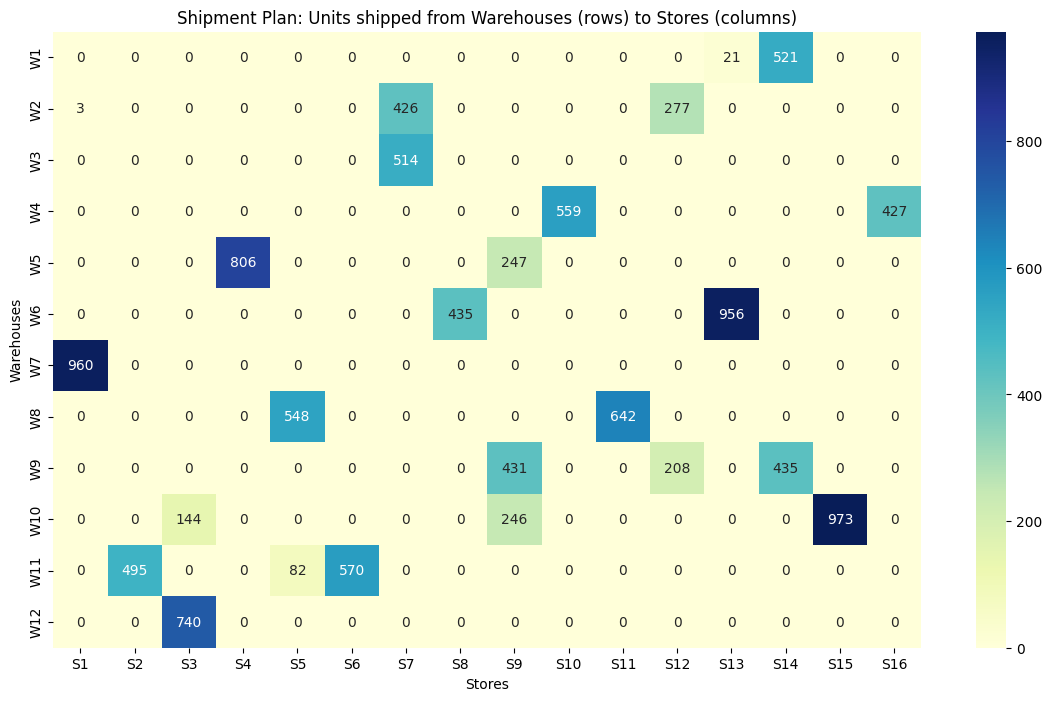

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of shipment plan
plt.figure(figsize=(14, 8))
sns.heatmap(shipment_plan, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Shipment Plan: Units shipped from Warehouses (rows) to Stores (columns)")
plt.xlabel("Stores")
plt.ylabel("Warehouses")
plt.show()


<ipython-input-17-bdc8990e7e7c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_shipments_warehouse.index, y=total_shipments_warehouse.values, palette="viridis")


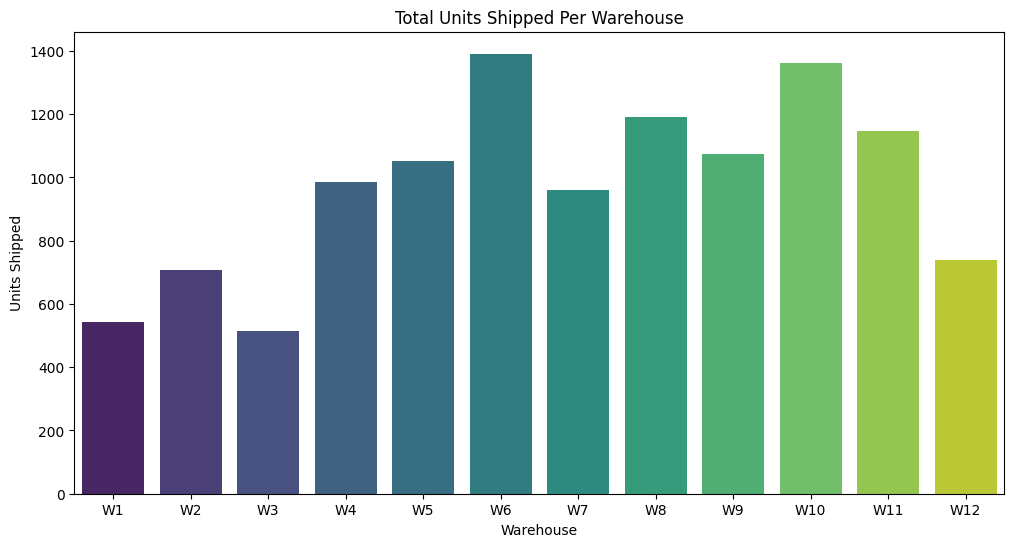

In [17]:
# Total shipments per warehouse
total_shipments_warehouse = shipment_plan.sum(axis=1)

plt.figure(figsize=(12, 6))
sns.barplot(x=total_shipments_warehouse.index, y=total_shipments_warehouse.values, palette="viridis")
plt.title("Total Units Shipped Per Warehouse")
plt.xlabel("Warehouse")
plt.ylabel("Units Shipped")
plt.show()


<ipython-input-18-0c5e65373254>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_shipments_store.index, y=total_shipments_store.values, palette="magma")


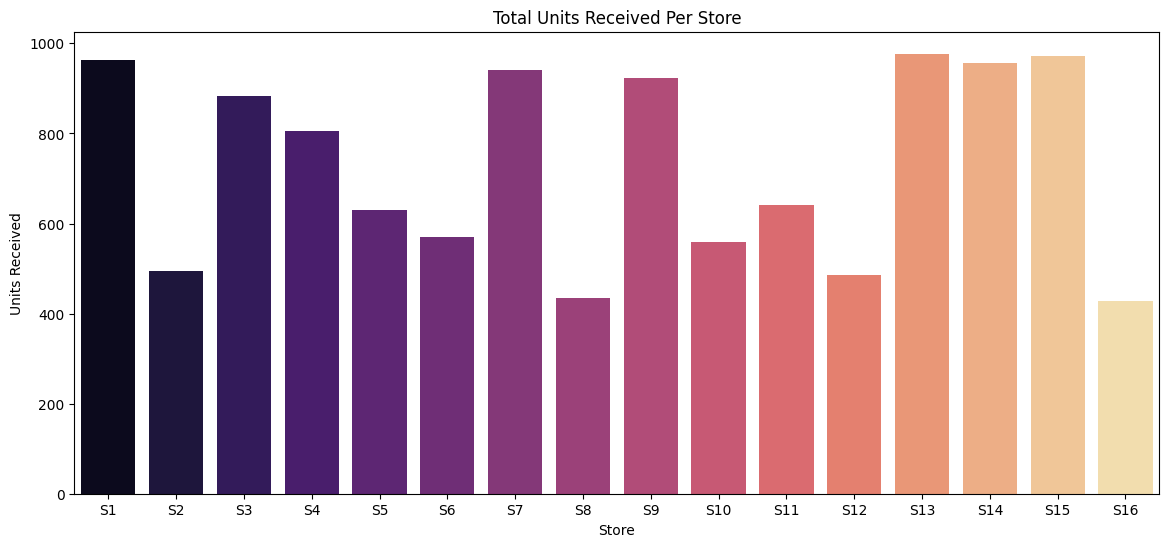

In [18]:
# Total shipments per store
total_shipments_store = shipment_plan.sum(axis=0)

plt.figure(figsize=(14, 6))
sns.barplot(x=total_shipments_store.index, y=total_shipments_store.values, palette="magma")
plt.title("Total Units Received Per Store")
plt.xlabel("Store")
plt.ylabel("Units Received")
plt.show()

## : Business Insights from Optimization Results

---

###  Optimization Summary

- **Model Status:** Optimal  
- **Total Cost (Shipping + Activation):** ₹55,022.00  
- **Activated Warehouses:** All 12 (W1 to W12)

---

###  1. All Warehouses Are Active — But Not Equally Utilized

Although every warehouse is activated, their usage levels vary:

| Warehouse | Total Units Shipped |
|-----------|----------------------|
| **W7**    | 960 (highest)        |
| **W5, W6, W9** | 800–900+ units   |
| **W1, W3, W12** | < 550 units     |

- **Key Insight**: Warehouses W7, W5, W6 are high-load hubs — likely servicing dense regions.
- Warehouses like W1, W3, W12 serve fewer stores and might be candidates for consolidation in future optimization.

---

###  2. Store-Level Demand Clustering

Notable patterns in store shipments:

- **S14**: Served by W1 (521 units) and W9 (435 units)
- **S12**: Shared between W2 (277) and W9 (208)
- **S7, S3, S4, S15**: Served solely by one warehouse each

- **Key Insight**: High-demand stores are often supported by multiple warehouses for load balancing.
- Some store-warehouse pairings are geographically or logistically optimal and consistent.

---

###  3. Cost vs. Operational Efficiency Trade-Off

Even with fixed activation costs (₹1000–₹1550):

- The model chose to **activate all 12 warehouses**, implying:
  - Shorter shipping distances saved enough cost to offset activation expenses.
  - Even low-volume warehouses added value by reducing transport distances.

- **Example**: W12 ships only to S3 (740 units), yet its activation was justified.

---

###  4. Redundancy and Resilience

- Stores like **S12** receive shipments from **multiple warehouses**.
- This reduces dependency on any one warehouse and offers resilience in case of disruptions or delays.

---

###  5. Business Recommendations

- **Evaluate low-volume warehouses** (e.g., W1, W3, W12) for cost-efficiency.
- **Segment stores by demand tiers**: focus inventory and service levels on high-volume stores (S14, S12, S13, S15).
- **Explore activation cost tuning**: Try increasing fixed costs to see how warehouse activation behavior changes.
- **Enhance model complexity** over time by incorporating:
  - Warehouse capacity limits
  - Delivery time constraints
  - Product variety and perishability
  - Multi-modal logistics

---

###  Conclusion

The optimized logistics plan balances shipping and operational costs well.  
It uses **proximity-based distribution** and **flexible warehouse usage** to keep costs minimal, while maintaining full coverage and network robustness.



##  Step 7: Conclusion and Wrap-Up

---

###  Problem Recap

In this project, we tackled a **realistic supply chain logistics optimization** problem using **Linear Programming** in Python with **PuLP**.  
We aimed to:

- Minimize the **total cost** of transporting goods from multiple warehouses to multiple stores.
- Include **warehouse activation costs**, mimicking operational realities.
- Ensure **supply meets demand** across the entire network.

---

###  What We Did

| Step | Description |
|------|-------------|
| **Step 1** | Imported libraries and initialized problem |
| **Step 2** | Defined dataset: 12 warehouses, 16 stores, costs, demands, and supplies |
| **Step 3** | Modeled decision variables, objective function, and constraints |
| **Step 4** | Added binary variables and activation costs for warehouses |
| **Step 5** | Solved the LP model using PuLP |
| **Step 6** | Analyzed results and extracted actionable insights |

---

###  Key Takeaways

- Linear programming is a powerful tool for **cost optimization** in logistics.
- Including real-world constraints like **fixed activation costs** makes models more practical and strategic.
- The results show a **balanced network** with demand met, minimal shipping cost, and all warehouses activated due to proximity and volume factors.
- Some warehouses are **under-utilized** and could be re-evaluated in future strategic planning.

---

###  Future Extensions

To make the model even more robust, we could consider:

- **Warehouse capacity limits** (maximum number of units that can be shipped from each)
- **Product categories and perishability**
- **Variable demand scenarios or seasonal spikes**
- **Carbon emissions or green logistics**
- **Time constraints / delivery SLAs**

---

###  Final Notes

- Optimization was successful with **status: Optimal**.
- Total cost (shipping + activation): **₹55,022.00**
- All **12 warehouses** were used effectively.

This notebook demonstrates how **mathematical modeling and Python-based optimization** can support smarter business decisions in supply chain management.

---

